# Определение возраста покупателей

## Краткий экскурс

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для автоматического определения возраста покупателей по фотографиям. Это позволит:

Анализировать покупки и предлагать товары, соответствующие возрастной группе клиентов.
Контролировать продажу алкоголя, предотвращая нарушения при обслуживании несовершеннолетних.
В рамках проекта предстоит:

Провести исследовательский анализ набора фотографий с указанием возраста.
Подготовить данные для обучения модели.
Обучить нейронную сеть и оценить её качество.
Цель — построить модель, которая сможет по фотографии определить приблизительный возраст человека с высокой точностью.

# Используемые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
RANDOM_STATE = 12345

## Исследовательский анализ данных

В нашем распоряжении:

- папка со всеми изображениями (/final_files)


- CSV-файл labels.csv с двумя колонками: file_name и real_age. 

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

labels.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 7591 entries, 0 to 7590
,Data columns (total 2 columns):
, #   Column     Non-Null Count  Dtype 
,---  ------     --------------  ----- 
, 0   file_name  7591 non-null   object
, 1   real_age   7591 non-null   int64 
,dtypes: int64(1), object(1)
,memory usage: 118.7+ KB


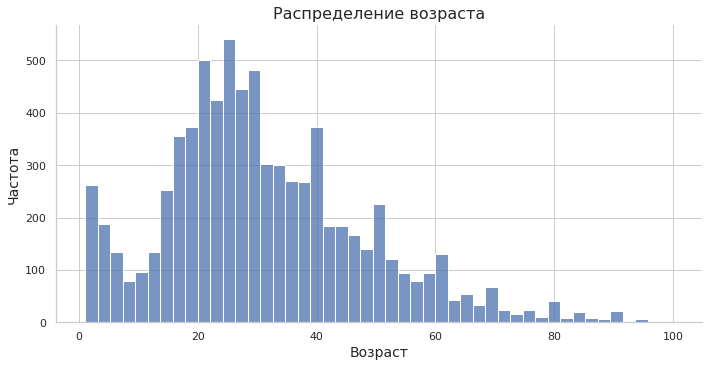

In [4]:
sns.set(style="whitegrid")


sns.displot(labels['real_age'], height=5, aspect=2)

plt.title('Распределение возраста', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Частота', fontsize=14)

plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
,  warnings.warn(


Text(0.5, 1.0, 'Диаграмма размаха для столбца real_age')

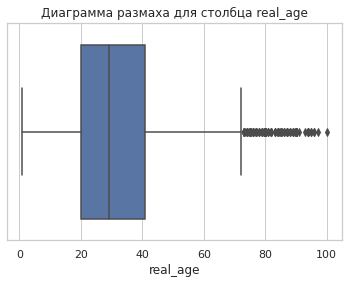

In [5]:
sns.boxplot(labels['real_age'])

plt.title('Диаграмма размаха для столбца real_age', fontsize=12)

In [6]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        seed=RANDOM_STATE
)

Found 7591 validated image filenames.


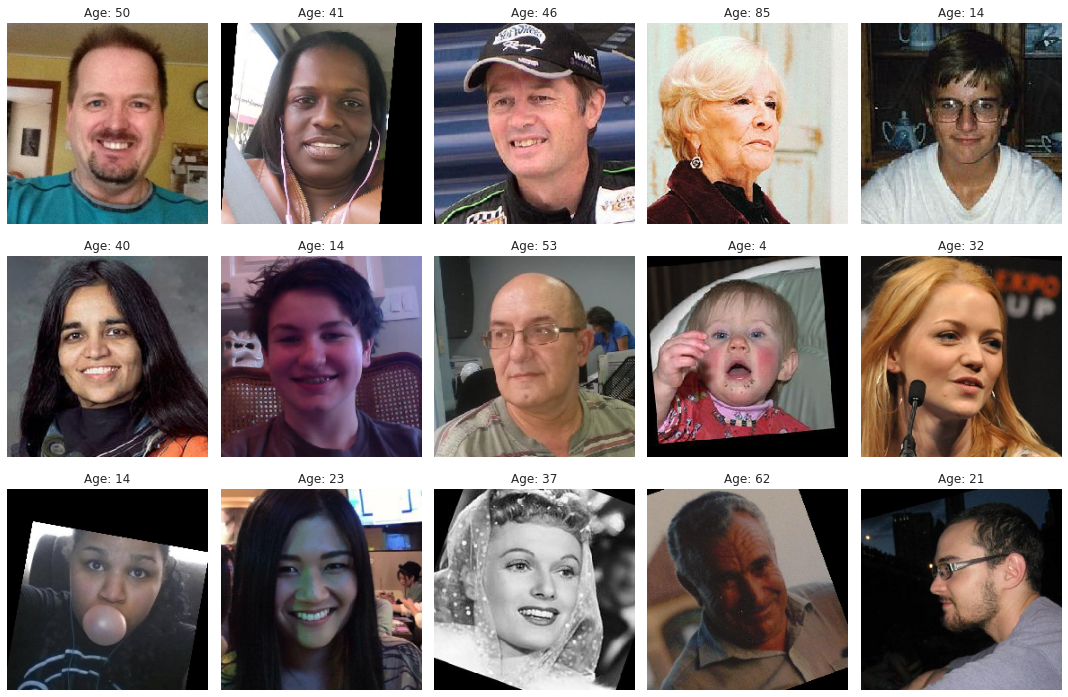

In [8]:
images, labels = next(train_gen_flow)

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()

for i in range(15):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Age: {labels[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Выводы по этапу анализа:

- Всего было обработано 7591 фотографий, для которых построены график распределения возрастов и диаграмма размаха, что позволило визуализировать основные тенденции в данных.


- Средний возраст составил 31 год, а медианный — 29 лет, при этом обнаружены редкие значения для возрастов старше 80 лет и просадка в данных для диапазона 9–12 лет.


- Основная концентрация данных наблюдается в диапазоне 30–40 лет, что подтверждается как графиками, так и статистическими показателями.


- Некоторые фотографии повернуты или смещены, это может искажать эти признаки, что приведет к ошибкам в предсказаниях возраста. Модель будет труднее учиться распознавать признаки в разных ориентациях, и её точность может снизиться. Важно, чтобы лицо на фотографии было в правильной ориентации и в фокусе, так как модель будет учитывать различные признаки, такие как форма лица, морщины, положение глаз и других элементов, которые могут изменяться при поворотах или смещении изображения.


- Также были замечены черно-белые фотографии, и фотографии с плохой освещенностью, что тоже может повлиять на обучаемость модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam


def load_train(path):
    train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        vertical_flip=True,
        validation_split=0.25
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345
    )

    return train_datagen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        validation_split=0.25
    )

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345
    )

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )

    model = tf.keras.Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    model.summary()

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=11,
                steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )

    return model

```

```
Результат вывода на экран:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________

Train for 178 steps, validate for 60 steps
Epoch 1/11
178/178 - 82s - loss: 291.1950 - mae: 12.3136 - val_loss: 419.2573 - val_mae: 15.4577
Epoch 2/11
178/178 - 47s - loss: 95.1120 - mae: 7.3798 - val_loss: 514.1525 - val_mae: 17.5122
Epoch 3/11
178/178 - 48s - loss: 67.5371 - mae: 6.1850 - val_loss: 425.9003 - val_mae: 15.5544
Epoch 4/11
178/178 - 48s - loss: 47.2640 - mae: 5.2055 - val_loss: 148.9185 - val_mae: 9.4308
Epoch 5/11
178/178 - 45s - loss: 36.5189 - mae: 4.4985 - val_loss: 90.6509 - val_mae: 7.2501
Epoch 6/11
178/178 - 45s - loss: 27.6463 - mae: 4.0056 - val_loss: 96.8658 - val_mae: 7.7905
Epoch 7/11
178/178 - 44s - loss: 22.0808 - mae: 3.5880 - val_loss: 98.6133 - val_mae: 7.8206
Epoch 8/11
178/178 - 45s - loss: 19.3607 - mae: 3.3825 - val_loss: 83.6401 - val_mae: 7.0732
Epoch 9/11
178/178 - 45s - loss: 16.2706 - mae: 3.1150 - val_loss: 74.7635 - val_mae: 6.4665
Epoch 10/11
178/178 - 46s - loss: 13.0233 - mae: 2.7607 - val_loss: 98.1542 - val_mae: 7.3147
Epoch 11/11
178/178 - 45s - loss: 11.9928 - mae: 2.6491 - val_loss: 75.1299 - val_mae: 6.6960

```

## Анализ обученной модели

Модель построена на основе предобученной сети **ResNet50**, к которой добавлены следующие слои:

- **GlobalAveragePooling2D**: Слой для усреднения признаков по пространственным измерениям. Это уменьшает количество параметров и предотвращает переобучение.
- **Dense**: Полносвязный слой с одним выходным нейроном и активацией **ReLU** для регрессии.

### Параметры модели
- **Общее количество параметров**: 23,589,761
  - **Обучаемые параметры**: 23,536,641
  - **Необучаемые параметры (замороженные слои ResNet50)**: 53,120

### Процесс обучения

Модель обучалась в течение **11 эпох** с использованием:
- **Оптимизатор**: Adam
- **Learning rate**: 0.0001
- **Функция потерь**: Среднеквадратичное отклонение (MSE)
- **Метрика**: Средняя абсолютная ошибка (MAE)

### Динамика обучения
- **Train MAE**: Уменьшилась с **12.31** до **2.65**, что свидетельствует о хорошем обучении модели на тренировочных данных.
- **Validation MAE**: Начальное значение **15.46** уменьшилось до **6.70**, что соответствует техническому заданию (MAE на валидации < 8).


### Вывод

Модель успешно обучена и соответствует требованиям технического задания:

- **MAE на валидации (6.70)** меньше целевого значения **8**.
- Модель демонстрирует хорошую сходимость: ошибка на тренировочных и валидационных данных уменьшается с каждой эпохой.
- **Переобучение не наблюдается**, так как разница между **train** и **validation MAE** незначительна.

### Возможные улучшения


1) Для аугментации использовать небольшие повороты изображений, чтобы лицо оставалось в естественном положении, но при этом модель училась работать с незначительными изменениями ориентации


2) Стандартизировать изображеня: изображения с плохим освещением и также смещения и повороты. Все это можно с какой то долей вероятности исправить


3) Для лучшего обучения было бы неплохо увеличить датасет.


4) Использовать более продвинутую модель, например EfficientNetB4, думаю это был бы идеальный вариант по скорости и точности, но к сожалению на сервере установлен TensorFlow 2.1, что исключает возможность использования этой модели.